### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [13]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [14]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [15]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [16]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [17]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

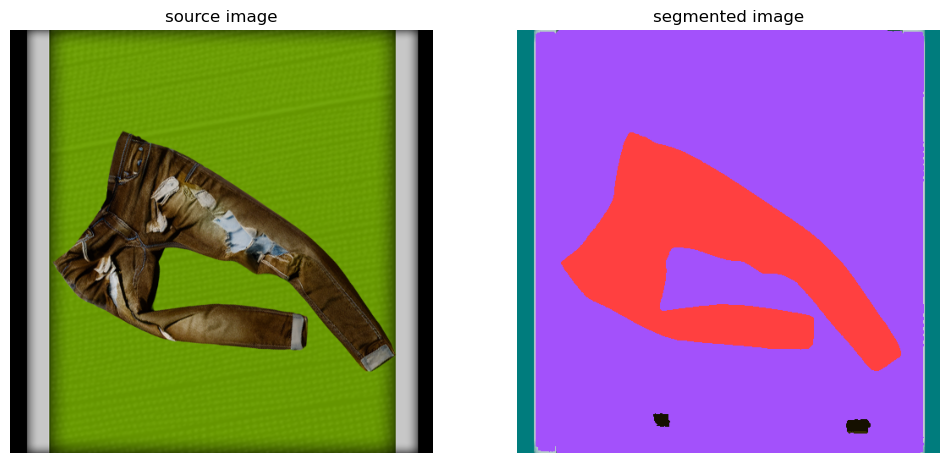

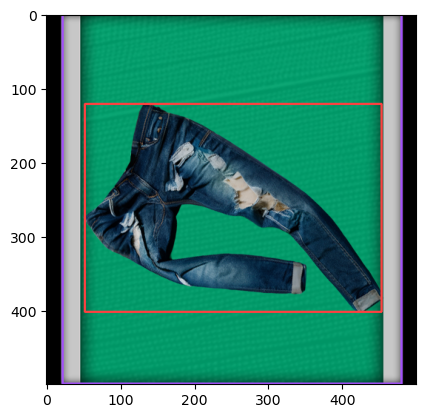

In [50]:
import cv2
import numpy as np

relative_path = get_training_data_path('production', 'pant')

file_names = []

# Walk through all files and directories recursively
for root, dirs, files in os.walk(relative_path):

    # Iterate over files in the current directory
    for i in range(20, 21):
        fullpath = os.path.join(relative_path, '20240527_183819.png')

        orig_image = Image.open(fullpath)
        orig_image = orig_image.rotate(0)
        #image = erase_generator(path=fullpath)
        n_image = np.array(orig_image)
        # Convert image to YCrCb color space, then apply blurring and shadow removal
        image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)


        blurred_image = cv2.medianBlur(image_ycrcb, 25)
        processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

        # Generate masks and filter them
        masks = mask_generator.generate(image_ycrcb)
        cleaned_masks = [mask for mask in masks if mask['area'] > 25000]

        # Annotation of the image
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
        detections = sv.Detections.from_sam(sam_result=cleaned_masks)
        annotated_image = mask_annotator.annotate(scene=processed_image.copy(), detections=detections)
        
        # Displaying images
        sv.plot_images_grid(
            images=[n_image, annotated_image],
            grid_size=(1, 2),
            titles=['source image', 'segmented image']
        )

        # Bounding box annotation on the original image for consistency
        bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
        final_annotated_image = bounding_box_annotator.annotate(
            scene=orig_image, detections=detections)

        plt.imshow(final_annotated_image)

In [19]:
def calculate_deviation_from_vertical(north, south):
    # Calculate the direction vector of the line connecting north and south
    vector = np.array(south) - np.array(north)
    
    # Calculate the angle of this vector with respect to the vertical axis
    angle_radians = np.arctan2(vector[0], vector[1])  # Use arctan2 to get the angle in radians
    angle_degrees = np.degrees(angle_radians)
    
    # The angle with respect to the vertical axis (90 degrees)
    deviation_from_vertical = 90 - np.abs(angle_degrees)
    
    return deviation_from_vertical

def calculate_deviation_from_horizontal(west, east):
    # Calculate the direction vector of the line connecting west and east
    vector = np.array(east) - np.array(west)
    
    # Calculate the angle of this vector with respect to the horizontal axis
    angle_radians = np.arctan2(vector[1], vector[0])  # Use arctan2 to get the angle in radians
    angle_degrees = np.degrees(angle_radians)
    
    # The angle with respect to the horizontal axis (0 degrees)
    deviation_from_horizontal = np.abs(angle_degrees)
    
    return deviation_from_horizontal

In [20]:
def calculate_rotation_angle(north, south, east, west):
    # Calculate vectors for both possible main axes
    vector_ns = np.array(north) - np.array(south)
    vector_ew = np.array(east) - np.array(west)
    
    # Calculate distances for both vectors
    distance_ns = np.linalg.norm(vector_ns)
    distance_ew = np.linalg.norm(vector_ew)
    
    # Determine the primary axis based on the longer distance
    if distance_ns > distance_ew:
        primary_vector = vector_ns
        print("NS dist longer")
    else:
        primary_vector = vector_ew
        print("EW dist longer")
    
    # Calculate the angle of the primary vector with respect to the vertical axis
    angle_radians = np.arctan2(primary_vector[1], primary_vector[0])
    print("ANGLE RADIANS")
    print(angle_radians)
    # Adjust the angle based on the primary axis
    if distance_ns > distance_ew:
        # For vertical primary axis, align with vertical
        print(np.degrees(angle_radians))
        angle_degrees = np.degrees(angle_radians) - 90
    else:
        # For horizontal primary axis, align with horizontal
        angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

def rotate_image(image, angle):
    # Get the image dimensions
    #(h, w) = image.shape[:2]
    h = 500
    w = 500
    # Calculate the center of the image
    center = (h // 2, w // 2)
    
    print("ANGLE DEGRESS")
    print(angle)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, -8, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    
    return rotated_image

def process_clothing_image(image, north, south, east, west):
    # Calculate the rotation angle needed to align the object with the vertical axis
    angle = calculate_rotation_angle(north, south, east, west)
    
    # Rotate the image to align the object north
    rotated_image_result = rotate_image(image, angle)
    
    return rotated_image_result

    import numpy as np



def get_extreme_points_from_mask(mask):
    # Extract coordinates from the mask
    coords = np.column_stack(np.where(mask))
    
    # Find the northernmost, southernmost, westernmost, and easternmost points
    northernmost = coords[np.argmin(coords[:, 0])]
    southernmost = coords[np.argmax(coords[:, 0])]
    westernmost = coords[np.argmin(coords[:, 1])]
    easternmost = coords[np.argmax(coords[:, 1])]
    
    # Function to get extreme points based on a specific y-coordinate
    def get_extreme_points_at_y(y, is_west):
        points_at_y = coords[coords[:, 0] == y]
        if is_west:
            return points_at_y[np.argmin(points_at_y[:, 1])]
        else:
            return points_at_y[np.argmax(points_at_y[:, 1])]

    # Find northernmost-west and northernmost-east points
    northernmost_west = get_extreme_points_at_y(northernmost[0], is_west=True)
    northernmost_east = get_extreme_points_at_y(northernmost[0], is_west=False)
    
    # Find southernmost-west and southernmost-east points
    southernmost_west = get_extreme_points_at_y(southernmost[0], is_west=True)
    southernmost_east = get_extreme_points_at_y(southernmost[0], is_west=False)
    
    return {
        "northernmost_west": northernmost_west,
        "northernmost_east": northernmost_east,
        "southernmost_west": southernmost_west,
        "southernmost_east": southernmost_east,
        "easternmost": easternmost,
        "westernmost": westernmost,
        "northernmost": northernmost,
        "southernmost": southernmost
    }



(500, 500)
{'northernmost_west': array([121, 133]), 'northernmost_east': array([121, 137]), 'southernmost_west': array([402, 422]), 'southernmost_east': array([402, 427]), 'easternmost': array([379, 453]), 'westernmost': array([274,  52]), 'northernmost': array([121, 133]), 'southernmost': array([402, 422])}
EW dist longer
ANGLE RADIANS
1.314700509045594
ANGLE DEGRESS
75.32679049201346


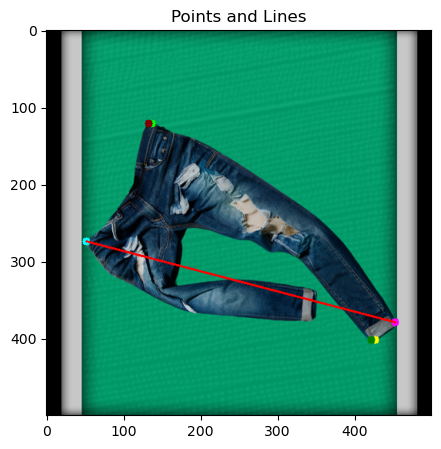

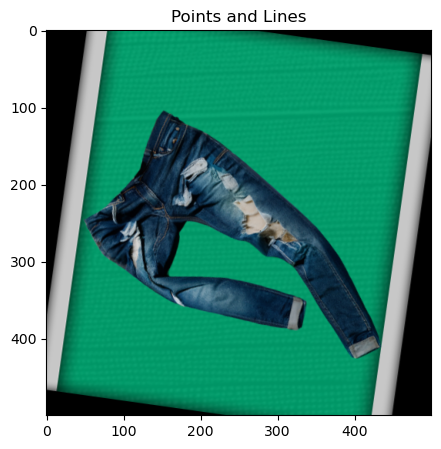

In [51]:
def plot_points(image, points_dict, radius=5):
    image = np.asarray(image)
    colors = {
        "northernmost_west": (255, 0, 0),
        "northernmost_east": (0, 255, 0),
        "southernmost_west": (0, 0, 255),
        "southernmost_east": (255, 255, 0),
        "easternmost": (255, 0, 255),
        "westernmost": (0, 255, 255),
        "northernmost": (128, 0, 0),
        "southernmost": (0, 128, 0)
    }

    for key, point in points_dict.items():
        cv2.circle(image, (point[1], point[0]), radius, colors[key], -1)
    
    # # Draw lines connecting the extreme points for visualization
    #cv2.line(image, (points_dict["northernmost"][1], points_dict["northernmost"][0]), (points_dict["easternmost"][1], points_dict["easternmost"][0]), (255, 0, 0), 2)
    cv2.line(image, (points_dict["westernmost"][1], points_dict["westernmost"][0]), (points_dict["easternmost"][1], points_dict["easternmost"][0]), (255, 0, 0), 2)
    #cv2.line(image, (points_dict["northernmost_east"][1], points_dict["northernmost_east"][0]), (points_dict["southernmost_east"][1], points_dict["southernmost_east"][0]), (0, 255, 0), 2)
    #cv2.line(image, (points_dict["easternmost"][1], points_dict["easternmost"][0]), (points_dict["southernmost"][1], points_dict["southernmost"][0]), (0, 0, 255), 2)
    #cv2.line(image, (points_dict["westernmost"][1], points_dict["westernmost"][0]), (points_dict["southernmost"][1], points_dict["southernmost"][0]), (0, 0, 255), 2)
    #cv2.line(image, (points_dict["southernmost_west"][1], points_dict["southernmost_west"][0]), (points_dict["southernmost_east"][1], points_dict["southernmost_east"][0]), (255, 255, 0), 2)
    
    # # Fixed reference lines (optional)
    # cv2.line(image, (250, 0), (250, 500), (0, 255, 255), 2) # vertical line
    # cv2.line(image, (0, 250), (500, 250), (0, 255, 255), 2) # horizontal line

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title("Points and Lines")
    plt.show()
    return image

def calculate_angle_between_lines(line1_point1, line1_point2, line2_point1, line2_point2):
    # Calculate direction vectors of the lines
    vector1 = np.array(line1_point2) - np.array(line1_point1)
    vector2 = np.array(line2_point2) - np.array(line2_point1)
    
    # Normalize the vectors
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    
    # Calculate the dot product of the normalized vectors
    dot_product = np.dot(unit_vector1, unit_vector2)
    
    # Ensure the dot product is within the valid range for arccos to avoid NaN errors due to floating-point precision issues
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

# Assume cleaned_masks and orig_image are defined elsewhere
mask = cleaned_masks[0]['segmentation']
bbox = cleaned_masks[0]['bbox']

if (bbox[1] + bbox[3] <= 490) and (bbox[1] >= 5):

    coords = np.column_stack(np.where(mask))

    north = coords[np.argmin(coords[:, 0])]
    south = coords[np.argmax(coords[:, 0])]
    west = coords[np.argmin(coords[:, 1])]
    east = coords[np.argmax(coords[:, 1])]

    print(orig_image.size)
    
    points = get_extreme_points_from_mask(mask)
    print(points)

    rot_image = process_clothing_image(np.array(orig_image), north, south, east, west)

#     print("ANG ANG")
#     ang = calculate_angle_between_lines(north, south, west, east)
#     print(ang)
    plot_points(orig_image, points)
    
#     deviation_v = calculate_deviation_from_vertical(north, south)

#     if deviation_v < 0:
#         deviation_v = -180 + deviation_v
    
    
#     print(f"Deviation from vertical: {deviation_v:.2f} degrees")
    
#     deviation_h = calculate_deviation_from_horizontal(west, east)
#     print(f"Deviation from horizontal: {deviation_h:.2f} degrees")

#     totla = (deviation_v + deviation_h) / 2


    plt.figure(figsize=(5, 5))
    plt.imshow(rot_image)
    plt.title("Points and Lines")
    plt.show()

else: 
    print('Object not fully visible... awaiting position change')

In [10]:
# masks_cleaned = []
# print(len(masks))
# for mask in masks: 
#     if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 200000):
#         print(mask['area'])
#         masks_cleaned.append(mask)

# masked_image = n_image
# x, y, w, h = cleaned_masks[0]['bbox']
# cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)
# cropped_image = masked_image[y:y+h, x:x+w]


# plt.imshow(cropped_image)

23.031338


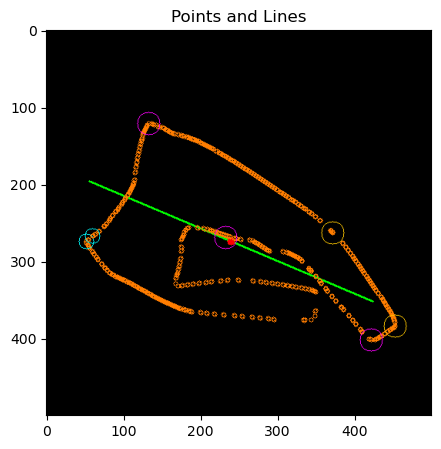

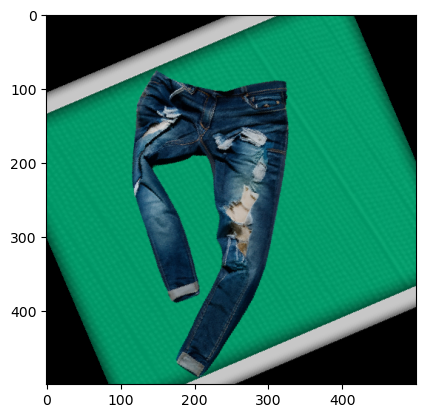

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_edge_points_from_mask_contours(mask):
    # Ensure mask is in the correct format (uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract edge points from contours
    edge_points = []
    for contour in contours:
        for point in contour:
            edge_points.append(point[0])
    
    return np.array(edge_points)

def plot_points(image, points, center_of_mass, radius=3):
    image = np.asarray(image)
    above_points = points[points[:, 1] < center_of_mass[1]]
    below_points = points[points[:, 1] > center_of_mass[1]]

    
    for i, point in enumerate(below_points):
        cv2.circle(image, (point[0], point[1]), radius, (255,125,0))

    for i, point in enumerate(above_points):
        cv2.circle(image, (point[0], point[1]), radius, (255,125,0))


    cv2.imwrite('./test.png', image)

    south = below_points[np.argmax(below_points[:, 1])]
    south_east = below_points[np.argmax(below_points[:, 0])]
    # easternmost = below_points[np.argmin(below_points[:, 1])]
    westernmost = below_points[np.argmin(below_points[:, 0])]

    cv2.circle(image, (center_of_mass[0], center_of_mass[1]), 15, (255,0,255))
    cv2.circle(image, (south[0], south[1]), 15, (255,0,255))
    cv2.circle(image, (south_east[0], south_east[1]), 15, (255,200,0))
    cv2.circle(image, (westernmost[0], westernmost[1]), 10, (0,255,255))

    for i, point in enumerate(above_points):
        cv2.circle(image, (point[0], point[1]), radius, (255,125,0))


    south = above_points[np.argmin(above_points[:, 1])]
    south_east = above_points[np.argmax(above_points[:, 0])]
    westernmost = above_points[np.argmin(above_points[:, 0])]

    cv2.circle(image, (center_of_mass[0], center_of_mass[1]), 15, (255,0,255))
    cv2.circle(image, (south[0], south[1]), 15, (255,0,255))
    cv2.circle(image, (south_east[0], south_east[1]), 15, (255,200,0))
    cv2.circle(image, (westernmost[0], westernmost[1]), 10, (0,255,255))



    # cv2.circle(image, (easternmost[0], easternmost[1]), 10, (0,255,255))

    # cv2.line(image, (easternmost[0], easternmost[1]),
    #          (westernmost[0], westernmost[1]),
    #          (0, 255, 255), 2)

    # cv2.line(image, (south_west[0], south_west[1]),
    #          (south_east[0], south_east[1]),
    #          (0, 255, 255), 2)

    # cv2.line(image, (easternmost[0], easternmost[1]),
    #          (westernmost[0], westernmost[1]),
    #          (0, 255, 255), 2)


    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title("Points and Lines")
    plt.show()
    return image

def get_extreme_points(edge_points):
    # Initialize extreme points
    northernmost = edge_points[np.argmin(edge_points[:, 1])]
    southernmost = edge_points[np.argmax(edge_points[:, 1])]
    easternmost = edge_points[np.argmax(edge_points[:, 0])]
    westernmost = edge_points[np.argmin(edge_points[:, 0])]

    return northernmost, southernmost, easternmost, westernmost

def get_center_of_mass(mask):
    # Ensure mask is in the correct format (uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Calculate the center of mass
    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
    else:
        cx, cy = 0, 0  # Set the center to (0, 0) if the mass is zero

    return np.array([cx, cy])

def get_extreme_points_above_below(edge_points, center_of_mass):
    above_points = edge_points[edge_points[:, 0] < center_of_mass[1]]
    below_points = edge_points[edge_points[:, 0] > center_of_mass[1]]

    # Get extreme points for the points above the center of mass
    northernmost_above = above_points[np.argmin(above_points[:, 1])]
    southernmost_above = above_points[np.argmax(above_points[:, 1])]
    easternmost_above = above_points[np.argmax(above_points[:, 0])]
    westernmost_above = above_points[np.argmin(above_points[:, 0])]

    # Get extreme points for the points below the center of mass
    northernmost_below = below_points[np.argmin(below_points[:, 1])]
    southernmost_below = below_points[np.argmax(below_points[:, 1])]
    easternmost_below = below_points[np.argmax(below_points[:, 0])]
    westernmost_below = below_points[np.argmin(below_points[:, 0])]

    return {
        "above": {
            "northernmost": northernmost_above,
            "southernmost": southernmost_above,
            "easternmost": easternmost_above,
            "westernmost": westernmost_above
        },
        "below": {
            "northernmost": northernmost_below,
            "southernmost": southernmost_below,
            "easternmost": easternmost_below,
            "westernmost": westernmost_below
        }
    }

def find_symmetry_line(edge_points):
# Convert edge points to float32 for PCA
    data_pts = np.array(edge_points, dtype=np.float32)

    # Compute PCA
    mean, eigenvectors = cv2.PCACompute(data_pts, mean=np.array([]))

    # The first eigenvector corresponds to the principal axis
    p1 = (int(mean[0, 0] - 200 * eigenvectors[0, 0]), int(mean[0, 1] - 200 * eigenvectors[0, 1]))
    p2 = (int(mean[0, 0] + 200 * eigenvectors[0, 0]), int(mean[0, 1] + 200 * eigenvectors[0, 1]))

    # Calculate the angle in degrees
    angle_rad = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])
    angle_deg = np.degrees(angle_rad)

    return mean[0], p1, p2, angle_deg


def plot_extreme_points_and_center(image, extreme_points, center_of_mass, radius=5):
    image = np.asarray(image)
    colors = {
        "northernmost_above": (255, 0, 0),        # Red
        "southernmost_above": (0, 255, 0),        # Green
        "easternmost_above": (0, 0, 255),         # Blue
        "westernmost_above": (255, 255, 0),       # Yellow
        "northernmost_below": (255, 128, 0),      # Orange
        "southernmost_below": (0, 255, 128),      # Light Green
        "easternmost_below": (0, 128, 255),       # Sky Blue
        "westernmost_below": (128, 255, 0),       # Lime Green
        "center_of_mass": (255, 0, 255)           # Magenta
    }


    for key, point in extreme_points["above"].items():
        cv2.circle(image, (point[0], point[1]), radius, colors[f"{key}_above"], -1)

    for key, point in extreme_points["below"].items():
        cv2.circle(image, (point[0], point[1]), radius, colors[f"{key}_below"], -1)

    # Plot the center of mass
    cv2.circle(image, (center_of_mass[0], center_of_mass[1]), radius, colors["center_of_mass"], -1)

    # Draw lines connecting westernmost to easternmost for above and below
    cv2.line(image, (extreme_points["above"]["westernmost"][0], extreme_points["above"]["westernmost"][1]),
             (extreme_points["below"]["easternmost"][0], extreme_points["below"]["easternmost"][1]),
             (0, 255, 255), 2)
    cv2.line(image, (extreme_points["above"]["northernmost"][0], extreme_points["above"]["northernmost"][1]),
             (extreme_points["below"]["southernmost"][0], extreme_points["below"]["southernmost"][1]),
             (0, 255, 255), 2)

    # cv2.line(image, (extreme_points["above"]["northernmost"][0], extreme_points["above"]["northernmost"][1]),
    #         (extreme_points["below"]["southernmost"][0], extreme_points["below"]["southernmost"][1]),
    #         (0, 255, 255), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Extreme Points and Center of Mass")
    plt.show()
    return image


# Get the edge points from the mask using contours
edge_points = get_edge_points_from_mask_contours(mask)
centroid, p1, p2, angle = find_symmetry_line(edge_points)
print(angle)
image = np.zeros((500, 500, 3), dtype=np.uint8)

cv2.line(image, p1, p2, (0, 255, 0), 2)
cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5, (255, 0, 0), -1)
center_of_mass = get_center_of_mass(mask)

plot_points(image, edge_points, center_of_mass)


rot = orig_image.rotate(-(90-angle))
plt.imshow(rot)
# # Get the extreme points above and below the center of mass
# extreme_points_above_below = get_extreme_points_above_below(edge_points, center_of_mass)

# print("Extreme Points Above and Below the Center of Mass:", extreme_points_above_below)
# print("Center of Mass:", center_of_mass)

# # Plot the extreme points and the center of mass on the image
# plot_extreme_points_and_center(orig_image, extreme_points_above_below, center_of_mass)
